###### Università degli Studi di Milano, Data Science and Economics Master Degree

# DQN
## Deep Q-Learning

### Alfio Ferrara

## The PONG environment
See [PONG](https://ale.farama.org/environments/pong/) for an environment description.

In [1]:
import ale_py
import gymnasium as gym
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

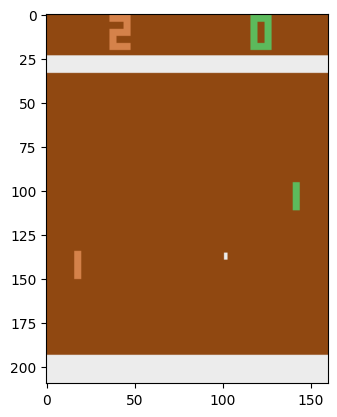

In [2]:
env = gym.make("ALE/Pong-v5", render_mode='rgb_array')
state, _ = env.reset()
done = False
for i in range(120):
    action = env.action_space.sample()
    next_state, reward, term, trunc, _ = env.step(action)
    done = term or trunc
    state = next_state
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    #time.sleep(.1)

In [3]:
print(state.shape)

(210, 160, 3)


## The DQN implementation
For this implementation we will use
- Feature extraction using a CNN network
- Experience replay
- A target network that evaluates the target independently from the main network
- A DDQN
See the classes in [DDQN](./gymbase/ddqn.py)

In [4]:
import gymbase.ddqn as dqn 
import numpy as np
from tqdm.notebook import tqdm

In [5]:
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 32
BUFFER_SIZE = 100000
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 1000000
TARGET_UPDATE_FREQ = 1000
TRAIN_START = 10000


In [6]:
def train(env: gym.Env, agent: dqn.DQNAgent, num_episodes: int):
    total_rewards = []

    for episode in tqdm(range(num_episodes), total=num_episodes):
        state, _ = env.reset()
        state = dqn.preprocess_frame(state)
        state_buffer = np.stack([state] * 4, axis=0)
        total_reward = 0
        done = False
        while not done:
            action = agent.exploration_policy(state_buffer)
            s_prime, reward, term, trunc, _ = env.step(action=action)
            next_state = dqn.preprocess_frame(s_prime)
            next_state_buffer = np.append(state_buffer[1:], np.expand_dims(next_state, axis=0), axis=0)
            
            # Put something into the replay memory
            agent.memory.push(state_buffer, action, reward, next_state_buffer, done)
            agent.train()

            state_buffer = next_state_buffer
            total_reward += reward

            done = term or trunc
        
        total_rewards.append(total_reward)
        if episode % TARGET_UPDATE_FREQ == 0:
            agent.update_target_network()
    env.close()
    return total_rewards


**DISCLAIMER**: training this architecture on Pong is super slow even on CUDA. The following code is just a snipped for showing the loop.

In [8]:
env = gym.make("ALE/Pong-v5", render_mode=None)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=100)

agent = dqn.DQNAgent(action_dim=env.action_space.n, learning_rate=LR, buffer_size=BUFFER_SIZE, epsilon_start=EPSILON_START,
                     epsilon_end=EPSILON_END, epsilon_decay_rate=EPSILON_DECAY, start_training=TRAIN_START, batch_size=BATCH_SIZE,
                     gamma=GAMMA)

num_episodes = 15
total_rewards = train(env=env, agent=agent, num_episodes=num_episodes)

  0%|          | 0/15 [00:00<?, ?it/s]

In [9]:
import seaborn as sns
import torch

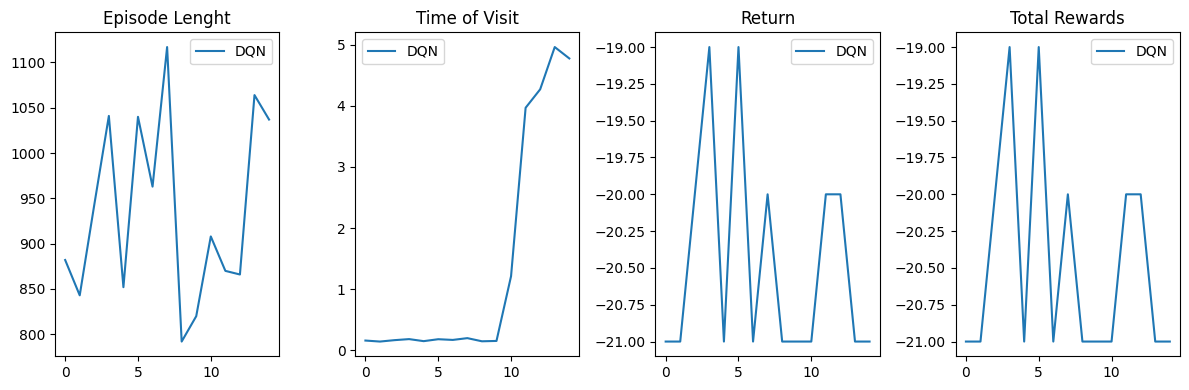

In [10]:
mlen, mtime, mret = env.length_queue, env.time_queue, env.return_queue

fig, ax = plt.subplots(figsize=(12, 4), ncols=4, nrows=1)
sns.lineplot(x=range(len(mlen)), y=mlen, ax=ax[0], label="DQN")
sns.lineplot(x=range(len(mtime)), y=mtime, ax=ax[1], label="DQN")
sns.lineplot(x=range(len(mret)), y=mret, ax=ax[2], label="DQN")
sns.lineplot(x=range(len(total_rewards)), y=total_rewards, ax=ax[3], label="DQN")
ax[0].set_title("Episode Lenght")
ax[1].set_title("Time of Visit")
ax[2].set_title("Return")
ax[3].set_title("Total Rewards")
plt.tight_layout()
plt.show()

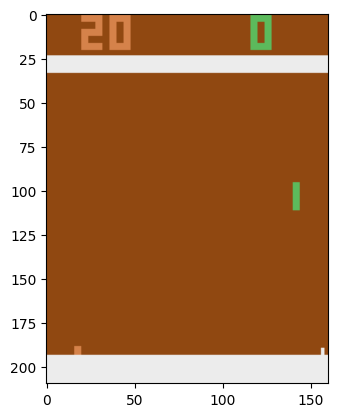

In [11]:
env = gym.make("ALE/Pong-v5", render_mode='rgb_array')
agent.q_network.eval()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

state, _ = env.reset()
state = dqn.preprocess_frame(state)
state_buffer = np.stack([state] * 4, axis=0)
done = False
while not done:
    state_tensor = torch.FloatTensor(state_buffer).unsqueeze(0).to(device)
    with torch.no_grad():
        action = torch.argmax(agent.q_network(state_tensor)).item()

    next_state, reward, term, trunc, _ = env.step(action)
    next_state = dqn.preprocess_frame(next_state)
    state_buffer = np.append(state_buffer[1:], np.expand_dims(next_state, axis=0), axis=0)
    done = term or trunc
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()